In [1]:
import random

def generate_random_tree(n):
  parent = {}
  nodes = list(range(n))
  random.shuffle(nodes)
  root = nodes[0]
  parent[root] = root
  for i in range(1, len(nodes)):
    parent[nodes[i]] = nodes[random.randrange(i)]
  return parent

import time
def get_node_depths(tree):
    depths = {}  # size of tree, node:level
    #curr = root
    for node in tree:
        level = 0
        curr = node
        while tree[curr] != curr:
            if curr in depths:
                level += depths[curr]
                break  
            curr = tree[curr]
            level += 1
        depths[node] = level
    return depths

def get_distance(tree, src, dest, depths):
    s = src; d = dest
    while s != d:
        if depths[d] > depths[s]:
            d = tree[d]
        elif depths[s] > depths[d]:
            s = tree[s]
        else:
            if s != d and depths[s] == depths[d]:
                d = tree[d]
    lca = s
    src_depth = depths[src] - depths[lca]
    dest_depth = depths[dest] - depths[lca]
    return (src_depth + dest_depth)

# src, dst, distance_label
#
def generate_dataset(N):
    dataset = []     # node1, node2, distance
    node_id = {}
    id_to_node = {}
    node_pairs = {}  # (node1, node2): distance
    
    counter = 0
    trees = {}
    depths_graph = {}
    # give each node a unique id
    for n in range(3, N): # For each tree
        trees[n] = generate_random_tree(n)
        tree = trees[n]
        depths_graph[n] = get_node_depths(tree)        
        for node in tree: # For each node in the tree
            node_id[(n, node)] = counter
#             id_to_node[counter] = n, node
            counter += 1
    
    for n in range(3, N):
        tree = trees[n]
        depths = depths_graph[n]
        if n%50 == 0:
            print("handling tree of size ", n)
        for node in tree:
            for other_node in tree:
                dist = get_distance(tree, node, other_node, depths)
                dataset.append([node_id[(n, node)], node_id[(n, other_node)], dist])
#                 node_pairs[(node_id[(n, node)], node_id[(n, other_node)])] = dist
                
    return dataset
# , node_pairs, id_to_node, node_id
# generate_dataset(10)

In [2]:
import networkx as nx

def get_graph_from_files(fileslist):
    dataset = []
    
    for file in fileslist:
        # create graph with networkx
        g = nx.read_edgelist(file, nodetype=int, create_using=nx.DiGraph)
        all_shortest_paths = nx.shortest_path_length(g)
        for all_paths in all_shortest_paths:
            src = all_paths[0]
            for dest in all_paths[1]:
              dataset.append([src, dest, all_paths[1][dest]])

        # optimize loops to use just one networkx function
        nx.draw(g)
    return dataset

In [3]:
from fastai.collab import *
from fastai.tabular.all import *

class CollabNN(Module):
    predictions = {}
    embeddings = {}
    def __init__(self, src_sz, y_range, n_act=200):
        self.node_factors = Embedding(*src_sz)
        self.layers = nn.Sequential(
            nn.Linear(src_sz[1]+src_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        self.prediction = None

    def forward(self, x):
        x_copy = torch.clone(x)
        embs = self.node_factors(x[:,0]), self.node_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        self.prediction = sigmoid_range(x, *self.y_range)

        for i in range(len(x)):
          pair = x_copy[i]
          CollabNN.predictions[(int(pair[0]),int(pair[1]))] = float(self.prediction[i])
          CollabNN.embeddings[int(pair[0])] = float(embs[0][i])
          CollabNN.embeddings[int(pair[1])] = float(embs[1][i])
        return self.prediction

    def get_predictions(self):
      return self.prediction

In [4]:
# %%capture captured
# import generator
# import model
import pickle
import torch
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.losses import *
import argparse
import torch.nn as nn


def get_small_emb_sz(dls_df):
    emb = get_emb_sz(dls_df)
    return [(emb[0][0], 1)]


def MRELoss(inp, targ) -> Tensor:
    inp = torch.flatten(inp).float()
    targ = torch.flatten(targ).float()
    nom = torch.nn.functional.l1_loss(inp, targ)
    noo = torch.Tensor([0]).repeat(targ.size(0)).to(device)
    denom = torch.nn.functional.l1_loss(noo, targ)
    loss = (nom / denom).mean()
    return loss


def CombineLoss(inp, targ) -> Tensor:
    mse_loss = MSELossFlat()
    loss_1 = mse_loss(inp, targ)

    loss_2 = MRELoss(inp, targ)

    return alpha * loss_1 + (1 - alpha) * loss_2

In [5]:
lg_N = 7
num_epochs = 200
alpha = 0.5
loss_function = CombineLoss


'''
Data can either be generated from scratch or read from a file that it was previously saved to
'''

savepath = 'save/' + str(alpha) + '_' + str(lg_N) + '_' + str(num_epochs) + '/'

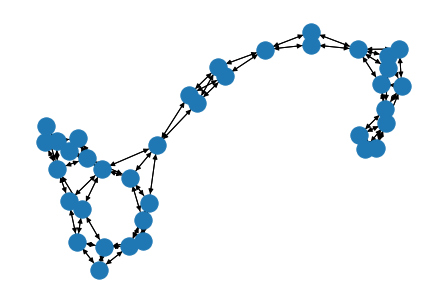

In [6]:
# dataset = generate_dataset(2**lg_N)

real_graph_paths = ["../datasets/ENZYMES_g1/ENZYMES_g1.edges"]
dataset = get_graph_from_files(real_graph_paths)

/thayerfs/home/f003wxq/.local/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,mse,mae,MRELoss,time
0,116.833229,107.869232,212.804047,14.260343,2.934436,00:00
1,107.885147,92.737465,182.765518,13.165087,2.709417,00:00
2,98.173775,77.971092,153.471909,12.001096,2.470275,00:00
3,87.898201,63.628254,125.042938,10.751630,2.213573,00:00
4,77.231636,49.974957,98.011780,9.410979,1.938137,00:00
5,66.333282,37.533585,73.419258,7.998396,1.647922,00:00
6,55.638725,26.917513,52.480972,6.568296,1.354054,00:00
7,45.588345,18.565329,36.051910,5.228889,1.078744,00:00
8,36.585045,12.615054,24.365055,4.193250,0.865052,00:00
9,28.941811,8.832739,16.936050,3.538275,0.729425,00:00


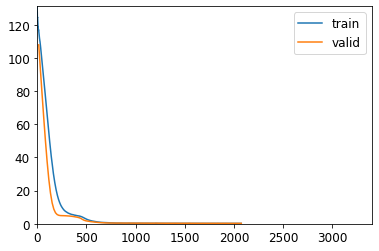

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = np.array(dataset)

# if loading from csv, cut the first column out (line numbers)
# df = pd.DataFrame(data[:, 1:], columns=['src', 'dst', 'label'])
# node_pairs = pd.read_pickle(savepath + 'node_pairs.pkl')
# node_id = pd.read_pickle(savepath + 'node_id.pkl')

# otherwise (if generated), use data directly
df = pd.DataFrame(data, columns = ['src','dst','label'])


dls_df = CollabDataLoaders.from_df(df, bs=64)
embs = get_small_emb_sz(dls_df)
trainer = CollabNN(*embs, y_range=(0, embs[0][0]))
# learn = Learner(dls_df, trainer, loss_func = loss_function, path=savepath)

learn = Learner(dls_df, trainer, loss_func=loss_function, path=savepath, metrics=[mse, mae, MRELoss])

# torch.save(trainer, modelpath + 'model.pth')
learn.save('model')
with open(savepath + "predictions.pkl", "wb") as outfile:
    pickle.dump(CollabNN.predictions, outfile)
with open(savepath + "embeddings.pkl", "wb") as outfile:
    pickle.dump(CollabNN.embeddings, outfile)

learn.load('model')
SaveModelCallback() #remove? with_opt=True), 
learn.fit_one_cycle(n_epoch=num_epochs, lr_max=5e-3, wd=0.01, 
                    cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.01, patience=250)])


In [ ]:
# learn.recorder()from fastai2.imports import *
# from fastai2.torch_core import *
# from fastai2.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    

In [ ]:
learn.recorder.plot_metrics()